# Dutch Corpora

In [1]:
# make sure installation has succeeded
import tempo_embeddings

In [2]:
%load_ext autoreload

In [3]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Database

In [4]:
%autoreload now

from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

In [5]:
from tempo_embeddings.embeddings.vector_database import ChromaDatabaseManager

MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"

db = ChromaDatabaseManager(db_path="testing_db_small_100_ctx", embedder_name=MODEL_NAME, batch_size=24)
db.connect()

duurzam_collection = db.get_existing_collection("anp_duurzam")
anp_duurzam = db.get_corpus(duurzam_collection, include_embeddings=True)

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Retrieved existing collection 'anp_duurzam'


In [6]:
for p in anp_duurzam.passages[:20]:
    print(len(p), p)

corpus = anp_duurzam
corpus.embeddings = db.compress_embeddings(corpus)

if corpus.embeddings is not None:
    print(corpus.embeddings.shape)

101 Passage('landbouw moet op basis zijn van de beginselen: wat is het meest duurzaam, hoe kunnen we de boeren een', {'': '2243', 'RecId': 'h-tk-20182019-18-10', 'chamber': 'TweedeKamer', 'date': '2018-11-01', 'highlighting': 'None', 'speakers': 'De voorzitter :|De voorzitter :|Minister Schouten :|De heer De Groot ( D66 ):|Minister Schouten :|Mevrouw Lodders ( VVD ):|Minister Schouten :|De heer Moorlag ( PvdA ):|Minister Schouten :|De voorzitter :|De heer Moorlag ( PvdA ):|Minister Schouten :|De heer Geurts ( CDA ):|Minister Schouten :|De voorzitter :|De heer Geurts ( CDA ):|Minister Schouten :|De heer Madlener ( PVV ):|Minister Schouten :|De voorzitter :|De heer Madlener ( PVV ):|De voorzitter :|De heer Madlener ( PVV ):|Minister Schouten :|De heer Madlener ( PVV ):|De voorzitter :|Minister Schouten :|De heer Madlener ( PVV ):|Minister Schouten :|Mevrouw Bromet ( GroenLinks ):|Minister Schouten :|Mevrouw Bromet ( GroenLinks ):|Minister Schouten :|De heer Futselaar ( SP ):|Minister Sch

Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Apr 26 15:18:01 2024 Finished embedding
(1520, 2)


## Read Stopwords

In [7]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

zsh:1: command not found: wget


In [8]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster

In [9]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"
FILTER_TERMS = ["duurzaam"] 
clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(2, [0, 3, 15, 45, 50, 55, 72, 82, 111, 115]), Subcorpus(1, [1, 61, 67, 85, 119, 122, 146, 157, 202, 203]), Subcorpus(13, [2, 33, 43, 59, 74, 109, 129, 204, 205, 225]), Subcorpus(21, [4, 6, 11, 19, 23, 26, 29, 37, 54, 65]), Subcorpus(-1, [5, 8, 16, 17, 18, 20, 24, 25, 28, 32]), Subcorpus(17, [7, 30, 63, 70, 79, 96, 171, 310, 337, 430]), Subcorpus(7, [9, 13, 14, 130, 169, 257, 260, 373, 381, 393]), Subcorpus(12, [10, 22, 38, 68, 94, 99, 120, 200, 206, 271]), Subcorpus(22, [12, 27, 36, 147, 263, 292, 301, 306, 362, 389]), Subcorpus(15, [21, 154, 190, 218, 234, 388, 470, 547, 652, 779]), Subcorpus(20, [31, 80, 150, 160, 165, 191, 299, 365, 519, 862]), Subcorpus(5, [35, 86, 92, 97, 114, 164, 168, 174, 175, 222]), Subcorpus(6, [40, 64, 71, 77, 139, 187, 201, 229, 268, 279]), Subcorpus(0, [41, 91, 100, 125, 167, 188, 189, 272, 274, 316]), Subcorpus(10, [47, 56, 101, 134, 180, 214, 232, 250, 262, 321]), Subcorpus(8, [53, 102, 546, 566, 645, 1032, 1129, 1143, 1337, 1436]), Subcorpus(

In [10]:
for cluster in clusters:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    print(cluster)

Subcorpus('bodembeheer; boeren; gezond; landbouw; voedsel', [0, 3, 15, 45, 50, 55, 72, 82, 111, 115])
Subcorpus('corporaties; huis; per; verduurzaamd; woningen', [1, 61, 67, 85, 119, 122, 146, 157, 202, 203])
Subcorpus('bereid; duurzaamheid; kabinet; mogelijk; vraag', [2, 33, 43, 59, 74, 109, 129, 204, 205, 225])
Subcorpus('debat; duurzaamheid; duurzaamheidscriteria; graag; heel', [4, 6, 11, 19, 23, 26, 29, 37, 54, 65])
Subcorpus('Outliers', [5, 8, 16, 17, 18, 20, 24, 25, 28, 32])
Subcorpus('blijft; dingen; duurzaamheid; toekomst; toekomstige', [7, 30, 63, 70, 79, 96, 171, 310, 337, 430])
Subcorpus('groep; inzetbaar; mensen; overwegende; werk', [9, 13, 14, 130, 169, 257, 260, 373, 381, 393])
Subcorpus('duurzaamheidsafspraken; duurzaamheidsdoelen; duurzaamheidsinitiatieven; probleem; zullen', [10, 22, 38, 68, 94, 99, 120, 200, 206, 271])
Subcorpus('d66; duurzaamheid; groenlinks; partij; vvd', [12, 27, 36, 147, 263, 292, 301, 306, 362, 389])
Subcorpus('dag; geweld; motie; orde; pijler', 

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
with open("clusters.txt", "wt") as f:
    for cluster in clusters:
        print(
            ", ".join(
                cluster.top_words(
                    exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5
                )
            ),
            file=f,
        )

# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

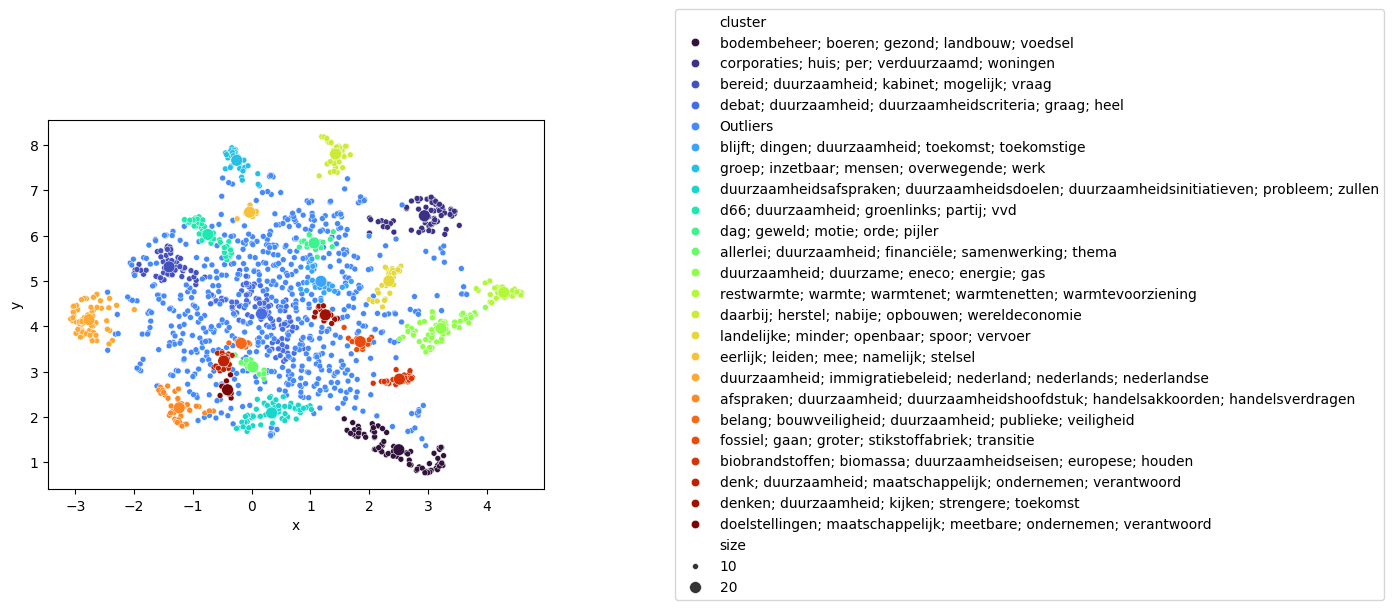

In [12]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [13]:
import os
from bokeh.io import output_notebook
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"

show(visualizer.create_document)

Loading BokehJS ...